In [1]:
# importing modules required

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as sc
import sklearn as sk
import statsmodels as st
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults
from matplotlib import pyplot, legend, figure
from pandas import DataFrame
from scipy.stats import boxcox
from array import *

warnings.filterwarnings("ignore")

In [2]:
# read excel that is filtered to top 5 countries (ghg emissions)
df = pd.read_csv('canada_ghg_all_sector.csv')

In [3]:
# get top 5 rows "df"
df.head()

Country Data source                        Sector      Gas    Unit  Year  \
0  Canada        CAIT                        Energy  All GHG  MtCO₂e  2018   
1  Canada        CAIT          Industrial Processes  All GHG  MtCO₂e  2018   
2  Canada        CAIT                   Agriculture  All GHG  MtCO₂e  2018   
3  Canada        CAIT                         Waste  All GHG  MtCO₂e  2018   
4  Canada        CAIT  Land-Use Change and Forestry  All GHG  MtCO₂e  2018   

   Gas Emitted  
0       626.07  
1        21.64  
2        58.95  
3        18.28  
4        38.51

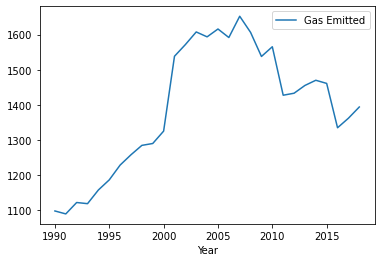

In [4]:
# plot time series of Year vs Gas Emitted - top5 countries (ghg)
top5_ghg_countries = df.groupby(['Year']).sum().plot()

In [5]:
# get top 5 rows of "top5_ghg_countries" after it have been summed, groupby year
top5_ghg_countries = df.groupby(['Year']).sum()
top5_ghg_countries.head()

Gas Emitted
Year             
1990      1097.37
1991      1088.96
1992      1121.47
1993      1118.16
1994      1157.19

In [6]:
reset_index = df.groupby(['Year']).sum().reset_index()

In [7]:
reset_index.columns

Index(['Year', 'Gas Emitted'], dtype='object')

In [8]:
year_2010 = reset_index.loc[reset_index['Year'] == 2010]

In [9]:
top5_ghg_countries['Gas Emitted']

Year
1990    1097.37
1991    1088.96
1992    1121.47
1993    1118.16
1994    1157.19
1995    1186.00
1996    1228.17
1997    1257.58
1998    1284.29
1999    1289.64
2000    1324.92
2001    1538.24
2002    1571.45
2003    1607.52
2004    1593.54
2005    1615.90
2006    1591.66
2007    1652.26
2008    1606.26
2009    1537.63
2010    1565.34
2011    1427.22
2012    1432.88
2013    1455.06
2014    1469.82
2015    1460.85
2016    1334.47
2017    1361.63
2018    1393.64
Name: Gas Emitted, dtype: float64

In [10]:
# top5_ghg_countries = top5_ghg_countries['Gas Emitted']

# naive prediction

# drop null values if there are

top5_ghg_countries.dropna(inplace=True)

# assigning training and testing dataset based on 50% split

top5_ghg_countries.dropna(inplace=True)

# assigning training and testing dataset based on 50% split
x = top5_ghg_countries.values

#x = x.astype('float32')
train_size = int(len(top5_ghg_countries) * 0.80)
train, test = x[0:train_size], x[train_size:]

In [11]:
# for every record from historical years, append into a list to be used for prediction

history = [x for x in train]
predictions_naive = list()

for i in range(len(test)):
    # predictions
    yhat = history[-1]
    predictions_naive.append(yhat)
    
    # observations
    obs = test[i]
    history.append(obs)
    print('>Predicted = %.3f, Expected = %3.f' % (yhat, obs))
    
# To calculate RMSE to see how well the model fits
mse = mean_squared_error(test, predictions_naive)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted = 1432.880, Expected = 1455
>Predicted = 1455.060, Expected = 1470
>Predicted = 1469.820, Expected = 1461
>Predicted = 1460.850, Expected = 1334
>Predicted = 1334.470, Expected = 1362
>Predicted = 1361.630, Expected = 1394
RMSE: 55.564


In [12]:
# ARIMA model 

# Dataset > period 1990 - 2003
# Validation set > period 2004 - 2018 
split_point = len(top5_ghg_countries) - 12
dataset, validation = top5_ghg_countries[0:split_point], top5_ghg_countries[split_point:]

# number of years used in each set
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# save each set into a csv file
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 17, Validation 12


In [13]:
# function arima

def evaluate_arima_model(X, arima_order):

    X = top5_ghg_countries.astype('float32')
    
    # assigning training and testing dataset based on 50% split
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # for every record from historical years, append into a list to be used for prediction
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        
        # expect trend to be non constant, hence trend = nc
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # To calculate RMSE to see how well the model fits
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

In [14]:
# search for optimal ARIMA parameters automatically

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA = %s \nRMSE = %.3f' % (best_cfg, best_score))

In [15]:
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(top5_ghg_countries.values, p_values, d_values, q_values)

Best ARIMA = None 
RMSE = inf


In [16]:
# Identify best ARIMA model manually

# check if stationary
result = adfuller(top5_ghg_countries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -1.689456
p-value: 0.436553
Critical Values:
	1%: -3.689
	5%: -2.972
	10%: -2.625


In [17]:
# By looking at the p-value of this test, we cannot reject the null hypothesis, 
#and it is likely that our dataset is non-stationary. We therefore choose the first parameter in 
#our ARIMA model (the p) as a 1. We do not choose a higher number because although our 
#dataset is non-stationary, it is not likely that seasonality is present because we work with annual data.

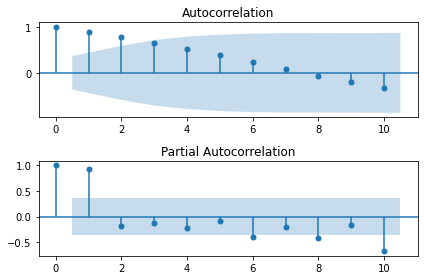

In [18]:
# Creates ACF and PACF plots
pyplot.figure()
pyplot.subplot(211)
plot_acf(top5_ghg_countries, ax=pyplot.gca(), lags = 10)
pyplot.subplot(212)
plot_pacf(top5_ghg_countries, ax=pyplot.gca(), lags = 10)
pyplot.tight_layout()
pyplot.show()

In [19]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # prediction
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    #observation
    obs = test[i]
    history.append(obs)

# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

                0
count    6.000000
mean    -4.761722
std     61.841315
min   -125.272120
25%     -5.097972
50%     16.776947
75%     27.680061
max     44.223071


In [20]:
# saving the ARIMA model

def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__

model = ARIMA(x, order=(1,0,0))
model_fit = model.fit(trend='nc', disp=0)

bias = -4.761722

model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

In [21]:
# load model and predict one period in the future

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 1387.212


In [22]:
# validate using dataset and validation set

# dataset
def difference(dataset):
        diff = list()
        for i in range(1, len(dataset)):
                value = dataset[i] - dataset[i - 1]
                diff.append(value)
        return diff

X = top5_ghg_countries.values
X = X.astype('float32')    

# difference data
stationary = difference(X)

df_X = pd.DataFrame({'Year': top5_ghg_countries.index.values, 'X':X.flatten()})

In [23]:
# validation set

validation = pd.read_csv('validation.csv')

def difference(validation):
        diff = list()
        for i in range(1, len(validation)):
                value = validation[i] - validation[i - 1]
                diff.append(value)
        return diff

y = np.array(validation['Gas Emitted'])
y = y.astype('float32')
      
stationary = difference(y)

df_y = pd.DataFrame({'Year': validation.index.values,'y':y.flatten()})


In [24]:
history = [x for x in X]

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')

>Predicted = 1387.212, Expected = 1652
>Predicted = 1647.498, Expected = 1606
>Predicted = 1601.498, Expected = 1538
>Predicted = 1530.384, Expected = 1565
>Predicted = 1558.173, Expected = 1427
>Predicted = 1419.833, Expected = 1433
>Predicted = 1425.571, Expected = 1455
>Predicted = 1447.824, Expected = 1470
>Predicted = 1462.655, Expected = 1461
>Predicted = 1453.747, Expected = 1334
>Predicted = 1329.708, Expected = 1362
>Predicted = 1354.442, Expected = 1394
RMSE: 96.91
MAE: 66.07


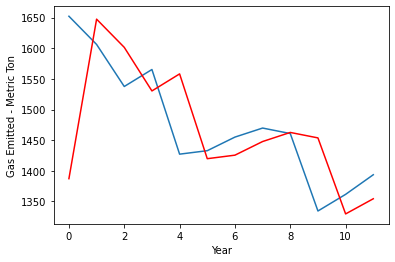

In [25]:
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted = %.3f, Expected = %3.f' % (yhat, y[0]))


for i in range(1, len(y)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)

    obs=y[i]
    history.append(obs)
    print('>Predicted = %.3f, Expected = %3.f' % (yhat, obs))
    

mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.2f' % rmse)
mae = mean_absolute_error(y, predictions)
print('MAE: %.2f' % mae)
# r2 = r2_score(y, predictions)
# print('R2: %.3f' % r2)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.xlabel('Year')
pyplot.ylabel('Gas Emitted - Metric Ton')
pyplot.show()

In [26]:
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
forecast = model_fit.forecast(steps=30)[0]
print (forecast)

[1391.9741594  1390.31031001 1388.64844944 1386.98857533 1385.33068529
 1383.67477695 1382.02084794 1380.3688959  1378.71891847 1377.07091329
 1375.42487799 1373.78081022 1372.13870764 1370.49856788 1368.86038861
 1367.22416749 1365.58990217 1363.95759031 1362.32722958 1360.69881764
 1359.07235218 1357.44783085 1355.82525134 1354.20461133 1352.58590849
 1350.96914052 1349.35430509 1347.74139991 1346.13042265 1344.52137103]


In [27]:
forecasted_year = 2019
a = 0
b = 29
forecasted_values = forecast[a]

for i in range(len(forecast)):
    try:
        print("Year "+ str(b) + " - " + str(forecasted_year), str(round(forecasted_values,2)))
        forecasted_year += 1
        a += 1
        b += 1
        forecasted_values = forecast[a]
    except:
        print('An exception occurred')
    

Year 29 - 2019 1391.97
Year 30 - 2020 1390.31
Year 31 - 2021 1388.65
Year 32 - 2022 1386.99
Year 33 - 2023 1385.33
Year 34 - 2024 1383.67
Year 35 - 2025 1382.02
Year 36 - 2026 1380.37
Year 37 - 2027 1378.72
Year 38 - 2028 1377.07
Year 39 - 2029 1375.42
Year 40 - 2030 1373.78
Year 41 - 2031 1372.14
Year 42 - 2032 1370.5
Year 43 - 2033 1368.86
Year 44 - 2034 1367.22
Year 45 - 2035 1365.59
Year 46 - 2036 1363.96
Year 47 - 2037 1362.33
Year 48 - 2038 1360.7
Year 49 - 2039 1359.07
Year 50 - 2040 1357.45
Year 51 - 2041 1355.83
Year 52 - 2042 1354.2
Year 53 - 2043 1352.59
Year 54 - 2044 1350.97
Year 55 - 2045 1349.35
Year 56 - 2046 1347.74
Year 57 - 2047 1346.13
Year 58 - 2048 1344.52
An exception occurred


Text(0, 0.5, 'Gas Emitted - Metric Ton')

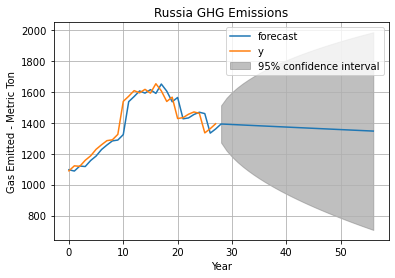

In [28]:
model_fit.plot_predict(1,57)
plt.grid()
plt.title('Russia GHG Emissions')
plt.xlabel('Year')
plt.ylabel('Gas Emitted - Metric Ton')

In [29]:
arr = (np.array([np.nan]))

In [30]:
for i in range(29):
    predictions.insert(0,arr)

In [31]:
year_2030 = predictions[40][0]
round(year_2030,2)

1354.44

In [32]:
year_2010['Gas Emitted']

20    1565.34
Name: Gas Emitted, dtype: float64

Text(0, 0.5, 'Gas Emitted - Metric Ton')

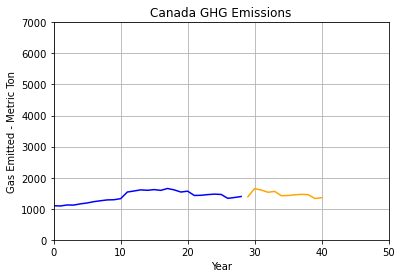

In [33]:
plt.grid()
plt.plot(predictions, color = 'orange' )
plt.plot(x, color = 'b')
plt.xlim ((0,50))
plt.ylim ((0,7000))
plt.title('Canada GHG Emissions')
plt.xlabel('Year')
plt.ylabel('Gas Emitted - Metric Ton')

In [34]:
for i in predictions:
    print(i[0])

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1387.2124374016025
1647.49828612662
1601.4982866673013
1530.3841526448027
1558.1731902760234
1419.8330396832666
1425.571389684841
1447.8244636269571
1462.6549757962525
1453.7466391762302
1329.7082448409412
1354.4416906265474
